# Feed a signal through a simple control system with feedback loop

Authors: Artem Basalaev <artemDOTbasalaev@pmDOTme>

If not done already, install spicypy (**uncomment the line below**):

In [1]:
#pip install spicypy

Note: on Windows the above might not work, you may see a compilation error in `ligo-segments` package. If this happens, please install `gwpy` separately first, by running `conda install -c conda-forge gwpy` in your terminal. (It must be an Anaconda environment, unfortunately currently there's no easy way to install on Windows without Anaconda. We are working on that)

## Creating a control system

Create a (an element of) control system using your favorite way supported by `python-control`. Then `spicypy` will try to convert it to `control.StateSpace` object using one of available conversion functions from `python-control`. The idea of encapsulating control system in `spicypy.System` instead of simply continuing with `python-control` is to allow tracking of how systems are connected (using either `feedback` or `*` for serial connection, or `+` for parallel connection). This history will be kept and in the future a plotting capability will be implemented to produce a diagram of the system.

Besides `spicypy` will directly connect signals in the form of `TimeSeries` from `gwpy`, see below for an example.

At the same time, all functionality available via `python-control` is preserved with `spicypy.System`, as it inherits from [`control.LinearICSystem`](https://python-control.readthedocs.io/en/latest/generated/control.LinearICSystem.html)

In [2]:
from control import tf, tf2ss, StateSpace
from spicypy.control.system import System

s = tf('s')
G = tf(1,1)
H = 50/s

#create a feedback system
sys_plant = System(G)
sys_ctrl = System(H)
sys = sys_plant.feedback(sys_ctrl)

sys2 = System(G/(1+G*H)) #equivalent definition using full TF for simple integrator with feedback
sys3 = System(tf([1,0], [1,50])) #equivalent definition with numerator and denominator coefficients

#equivalent definition using StateSpace
A=[[-50.]]
B=[[1.]]
C=[[-50.]]
D=[[1.]]
sys4 = System(StateSpace(A,B,C,D)) 

Info: supplied transfer function was converted to control.StateSpace using control.tf2ss()
Info: supplied transfer function was converted to control.StateSpace using control.tf2ss()
Info: supplied control.StateSpace
Info: supplied transfer function was converted to control.StateSpace using control.tf2ss()
Info: supplied transfer function was converted to control.StateSpace using control.tf2ss()
Info: supplied control.StateSpace


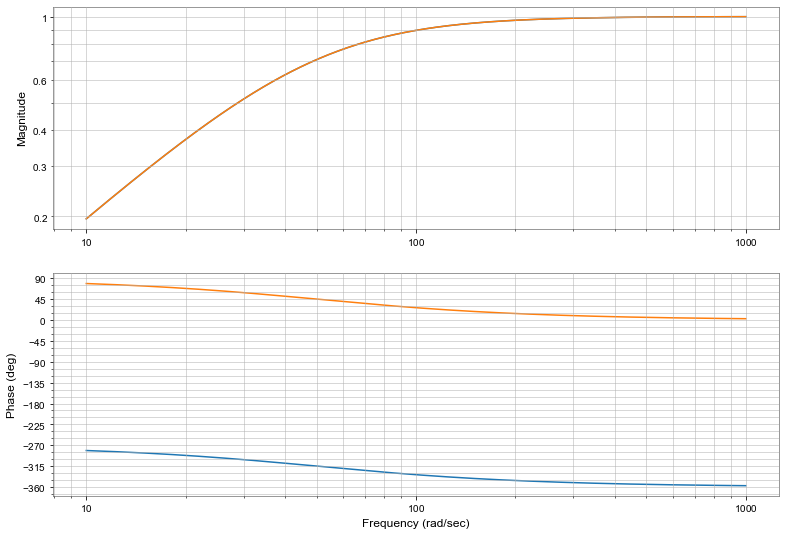

In [7]:
from control import tf, ss2tf
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
plt.rcParams["figure.figsize"] = (13,9)

from control import bode

bode([ss2tf(sys), ss2tf(sys2)])

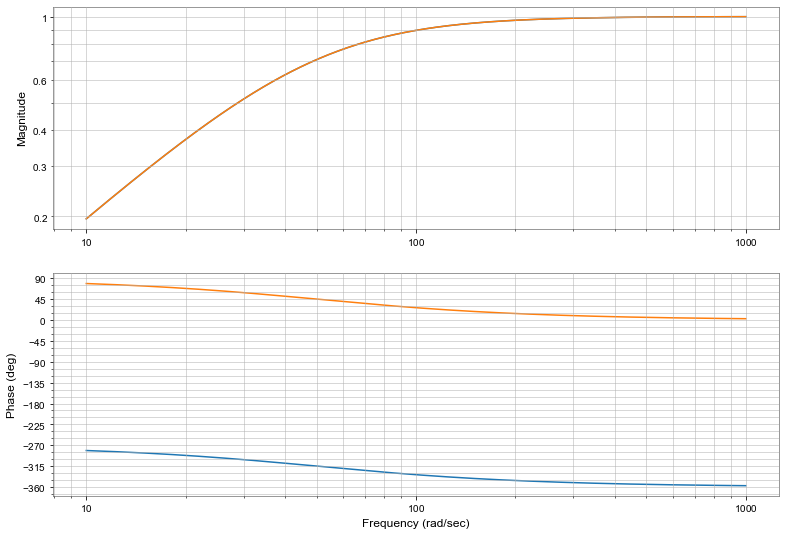

In [4]:
bode([ss2tf(sys3), ss2tf(sys4)])

## Creating a test signal and feeding it through the control system

Now create some test data and convert it to `spicypy.TimeSeries`. This class directly inherits from `gwpy.TimeSeries` making all corresponding functionality available. Plus there's expended functionality, such as possibility to calculate spectra with `lpsd` and `daniell` averaging methods.

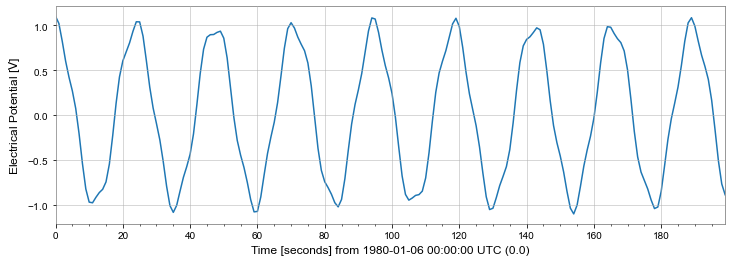

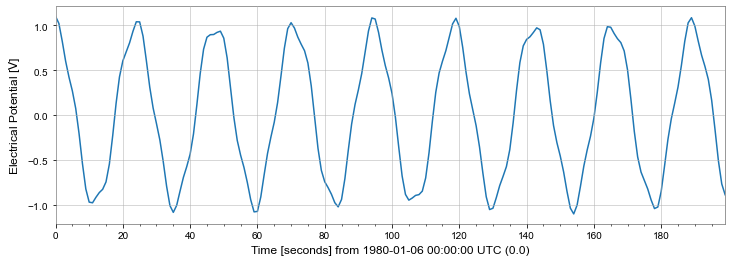

In [5]:
import numpy as np

a=np.zeros(200)
t=np.zeros(200)

for k in range(200):
    t[k]=k
    a[k] = np.cos(50*float(k)) + 0.1*np.cos(float(k))

from spicypy.signal.time_series import TimeSeries

ts = TimeSeries(a, times=t, unit="V")
ts.plot()

Now we can send this signal through our control system and see what happens:

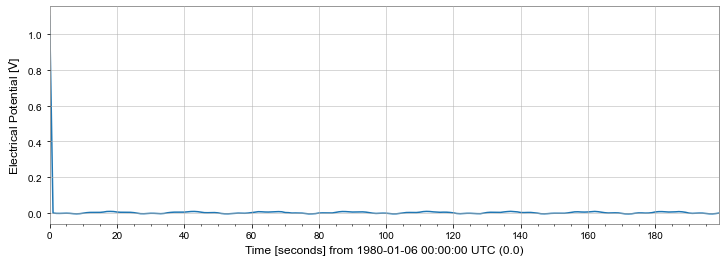

In [6]:
ts2 = sys.response(ts)
plot = ts2.plot()